[array([-0.60229691, -0.1424394 , -0.78546129]), array([-0.31742977,  0.54172457,  0.7783141 ]), array([-0.28514317, -0.94102754, -0.18210034]), array([-0.26437311,  0.55810846,  0.78652515]), array([-0.73567674,  0.5267048 ,  0.42586592]), array([ 0.0333064 ,  0.33864433, -0.94032478]), array([ 0.09416991, -0.87956406,  0.46636798]), array([ 0.29198908, -0.30543013,  0.90634144]), array([-0.83880008,  0.47198778, -0.27137051]), array([0.40456252, 0.18790115, 0.8949985 ]), array([ 0.27809195,  0.76014447, -0.58723527]), array([ 0.92014944, -0.1494984 , -0.36190501]), array([ 0.52342351,  0.69642404, -0.49093929]), array([ 0.49764725, -0.86300067,  0.08704633]), array([-0.76063878, -0.18919044,  0.62099567]), array([-0.03279402,  0.20236764, -0.97876039]), array([-0.32937597,  0.92742049, -0.17720806]), array([0.93532894, 0.29312994, 0.19807731]), array([ 0.14975599, -0.22886997, -0.96186885]), array([-0.69000027,  0.72175864,  0.05444356]), array([0.60629227, 0.08464642, 0.79072414]), 

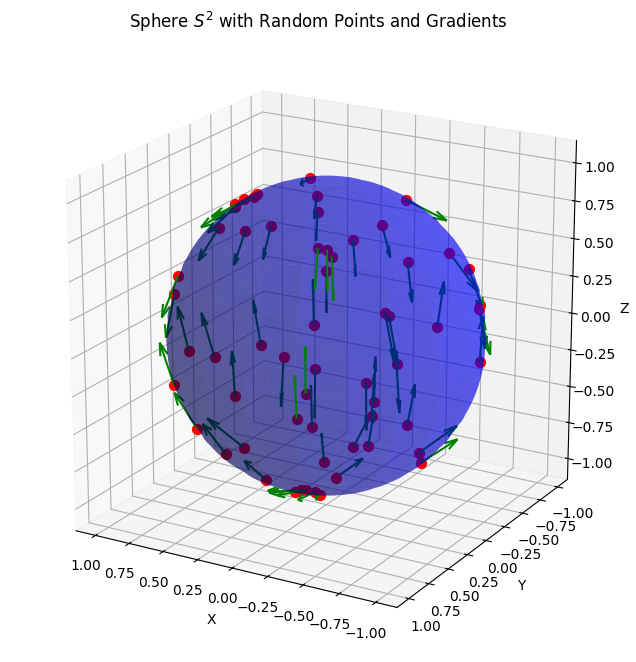

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy


class RiemannianManifold:

  def __init__(self, n=3):
    self.dim = n - 1

  def project_to_tangent_space(self, x, v):
    return v - np.dot(x, v) * x

  def retraction(self, x, eta):
    y = x + eta
    return y / np.linalg.norm(y)

  def gradient(self, f, x, eps=1e-8):
    grad = np.zeros_like(x)
    for i in range(len(x)):
      e_i = np.zeros_like(x)
      e_i[i] = 1
      grad[i] = (f(x + eps * e_i) - f(x - eps * e_i)) / (2 * eps)
    return self.project_to_tangent_space(x, grad)

  def random_point(self):
    vec = np.random.randn(self.dim + 1)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

  def random_dist(self):
    theta = np.random.uniform(0, 2 * np.pi)
    phi = np.random.uniform(0, np.pi)
    x = np.array([
        np.sin(phi) * np.cos(theta),
        np.sin(phi) * np.sin(theta),
        np.cos(phi)
    ])
    return x
  
  def cost_function(self, x):
    A = np.eye(self.dim + 1)
    A[-1,-1] = -1
    return x.T @ A @ x
  
  def gradient(self, x):
    A = np.eye(self.dim + 1)
    A[-1,-1] = -1
    return 2 * (A @ x - x * self.cost_function(x))
  
  def armijo_point(self, x, alpha=3, beta=0.2, sigma=0.05):
    eta = -1.0 * self.gradient(x)
    f = self.cost_function
    m = 0
    while True:
      Rx = self.retraction(x, beta**m * np.conj(alpha) * eta)
      lower = (-1.0 * sigma * self.gradient(x)) @ ((beta**m) * alpha * eta)
      if f(x) - f(Rx) >= lower:
        return alpha * (beta**m)
      m += 1

  def g(x,y):
    return np.trace(x.T @ y)
  
  def retraction(self,x,xi):
    y = x + xi
    return np.divide(y,np.linalg.norm(y,2))
  
  def search(self,x0):
    XS = [x0]
    ES = []
    i = 0
    for i in range(1000):
      etak = (-1.0) * self.gradient(x0)

      ES.append(etak)
      if np.linalg.norm(etak) < 1e-4: break
      tk = self.armijo_point(x0)
      x0 = self.retraction(x0, tk * etak)
      XS.append(x0)
    return (np.array(XS), np.array(ES))



sphere = RiemannianManifold()


def quadratic_function(x):
  return np.dot(x, x)


points = [sphere.random_point() for _ in range(60)]
print(points)
grads = [sphere.gradient(x) for x in points]


def plot_sphere_with_gradients(points, gradients):
  u = np.linspace(0, 2 * np.pi, 100)
  v = np.linspace(0, np.pi, 100)

  x_sphere = np.outer(np.cos(u), np.sin(v))
  y_sphere = np.outer(np.sin(u), np.sin(v))
  z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  ax.plot_surface(x_sphere,
                  y_sphere,
                  z_sphere,
                  color='b',
                  alpha=0.4,
                  rstride=5,
                  cstride=5,
                  linewidth=0)

  for point, gradient in zip(points, gradients):
    ax.scatter(point[0], point[1], point[2], color='r', s=50)
    ax.quiver(point[0],
              point[1],
              point[2],
              gradient[0],
              gradient[1],
              gradient[2],
              color='g',
              length=0.1 * np.linalg.norm(gradient, 0),
              normalize=True)

  ax.view_init(elev=20, azim=120)

  ax.set_title("Sphere $S^2$ with Random Points and Gradients")
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_box_aspect([1, 1, 1])

  plt.show()


# Generate and plot the points
plot_sphere_with_gradients(points, grads)


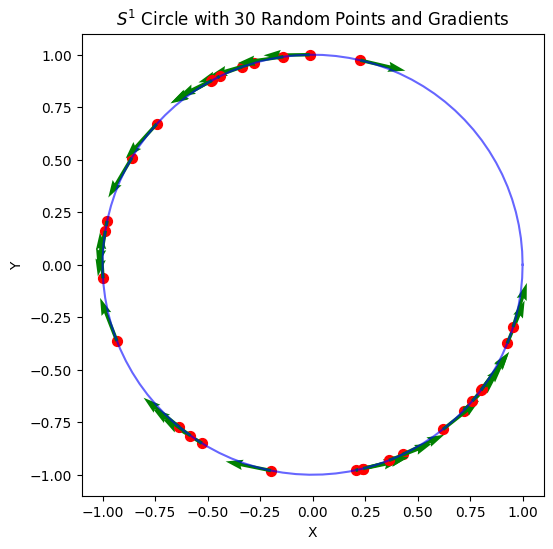

In [49]:
circle = RiemannianManifold(n = 2)

circle_points = [circle.random_point() for _ in range(30)]
circle_gradients = [circle.gradient(x) for x in circle_points]

def plot_circle_with_gradients(points, gradients):
    theta = np.linspace(0, 2 * np.pi, 100)
    x_circle = np.cos(theta)
    y_circle = np.sin(theta)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(x_circle, y_circle, color='b', alpha=0.6)  # Circle

    for point, gradient in zip(points, gradients):
        ax.scatter(point[0], point[1], color='r', s=50)
        ax.quiver(point[0], point[1], gradient[0], gradient[1], color='g', scale=10*np.linalg.norm(gradient,axis=0))


    ax.set_title("$S^1$ Circle with 30 Random Points and Gradients")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_aspect('equal', 'box')

    plt.show()

plot_circle_with_gradients(circle_points, circle_gradients)


## Retraction on the sphere

Let $M = S^{n-1}$ and $N$ the positive Reals. Then the mapping
$$
  \phi : M \times N \to \mathbb{R}_{*}^{n}: (x,r) \mapsto xr.
$$ 
is a Diffeomorphism.

The inverse map $\phi^{-1} : \mathbb{R}^n \to M \times N$ is easy to figure out: Because all Elements of $S^{n-1}$ are unit vectors, $x$ is given by $\frac{v}{\left| v \right|}$ and $r$ is given by $\left|v\right|$.

Then it is easy to see that the Retraction on the N-Sphere is given by $R_x(\xi) = \frac{x + \xi}{\left| x + \xi \right|}$


/tmp/ipykernel_570628/1517543374.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(path[:, 0], path[:, 1], cmap="winter", marker='o')
/tmp/ipykernel_570628/1517543374.py:36: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


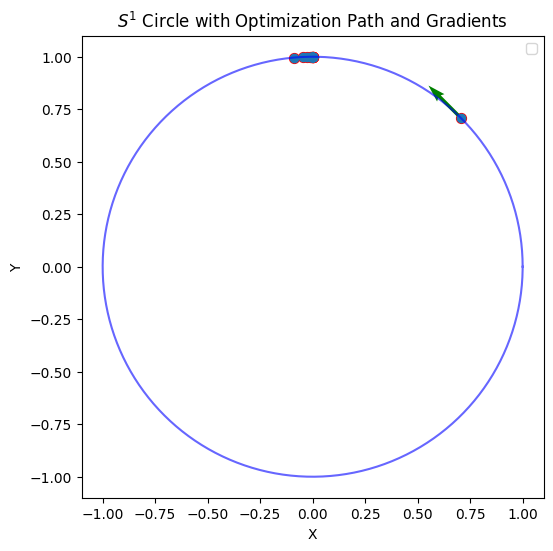

30


In [50]:





theta = np.pi / 4  # Azimuthal angle
phi = np.pi / 4  # Polar angle
x0 = np.array((np.cos(theta),np.sin(phi)),dtype=float)


circle = RiemannianManifold(n = 2)


path, gradients = circle.search(x0)


def plot_sphere_with_path_and_gradients(points, gradients, path):
  theta = np.linspace(0, 2 * np.pi, 500)
  x_circle = np.cos(theta)
  y_circle = np.sin(theta)

  fig, ax = plt.subplots(figsize=(6, 6))
  ax.plot(x_circle, y_circle, color='b', alpha=0.6)

  for point, gradient in zip(points, gradients):
    ax.scatter(point[0], point[1], color='r', s=50)
    ax.quiver(point[0],
              point[1],
              gradient[0],
              gradient[1],
              color='g',
              scale=10 * np.linalg.norm(gradient, 0))

  ax.scatter(path[:, 0], path[:, 1], cmap="winter", marker='o')

  ax.set_title("$S^1$ Circle with Optimization Path and Gradients")
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_aspect('equal', 'box')

  plt.legend()
  plt.show()


plot_sphere_with_path_and_gradients(path, gradients, path)
print(path.size)


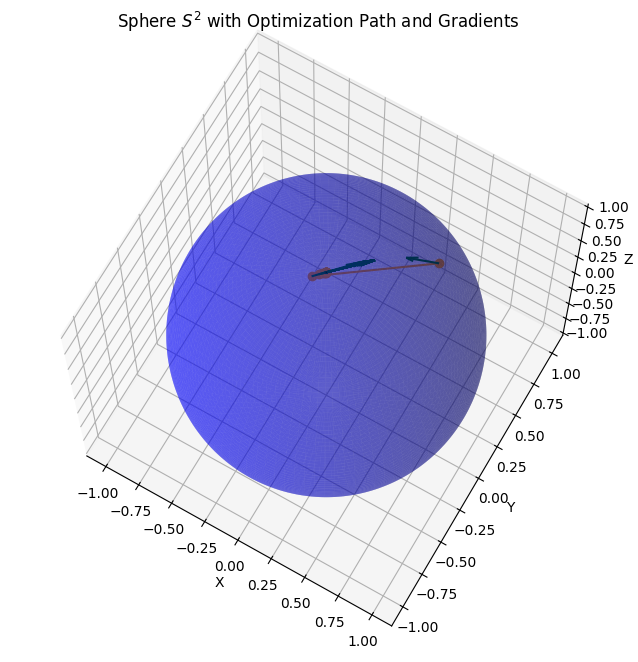

45


In [52]:



path, gradients = sphere.search(x0 = np.array(
      [np.sin(phi) * np.cos(theta),
       np.sin(phi) * np.sin(theta),
       np.cos(phi)]))


def plot_sphere_with_path_and_gradients(points, gradients, path):
  u = np.linspace(0, 2 * np.pi, 500)
  v = np.linspace(0, np.pi, 500)

  x_sphere = np.outer(np.cos(u), np.sin(v))
  y_sphere = np.outer(np.sin(u), np.sin(v))
  z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')

  ax.plot_surface(x_sphere,
                  y_sphere,
                  z_sphere,
                  color='b',
                  alpha=0.4,
                  rstride=5,
                  cstride=5,
                  linewidth=0)

  ax.plot(path[:, 0],
          path[:, 1],
          path[:, 2],
          color='orange',
          marker='o',
          label='Optimization Path')

  for point, gradient in zip(path, gradients):
    ax.quiver(point[0],
              point[1],
              point[2],
              gradient[0],
              gradient[1],
              gradient[2],
              color='g',
              length=0.3,
              normalize=True)

  ax.view_init(elev=70, azim=300)

  ax.set_title("Sphere $S^2$ with Optimization Path and Gradients")
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.set_box_aspect([1, 1, 1])

  plt.show()


plot_sphere_with_path_and_gradients(path, gradients, path)
print(path.size)

## Stiefel Manifold

$$ St(n,p) = \{ X \in \mathbb{R}^{n \times p} \mid X^T X = I_p \} $$

In [8]:
from scipy.linalg import qr

def g(x,y):
  return np.trace(x.T @ y)

def qf(X):
  return qr(X)[0]
  

def random_point(n,p):
  A = np.random.randn(n,p)
  return  qr(A)[0]

A = random_point(2,2)

def check_is_stiefel(X):
  size = X.shape[0]
  A = X.T @ X
  return np.allclose(A,np.eye(size),10e-3)

def project_to_tangent_space(X,Z):
  I = np.eye(X.shape[0])
  M = X.T @ Z
  skew = 1/2 * (M - M.T)
  proj = (I - X@X.T)@Z - X@skew
  return proj

def st_retraction_1(x,xi):
  return qf(x + xi)

def st_retraction_2(x,xi):
  return (x + xi) @ (np.eye(x.shape[0]) + xi.T @ xi)**(-0.5)



B = np.eye(2)

C = project_to_tangent_space(A,B.T)

C

array([[ 0.00000000e+00, -1.19061464e-16],
       [-1.19061464e-16,  0.00000000e+00]])